# 🧠 Fake News Classification — NLP Final Project
Мета цього проєкту — створити модель, яка може класифікувати новини як **фейкові** (`is_fake = 1`) або **правдиві** (`is_fake = 0`).

Це повноцінний ML-процес: від попереднього аналізу текстів до побудови моделей та порівняння їх якості.

## 📥 1. Імпорти та завантаження даних

In [3]:
import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score

In [4]:
df = pd.read_csv("fake_news_full_data.csv")
df = df.dropna(subset=["text", "title", "is_fake"])
df.head()

,Unnamed: 0,title,text,date,is_fake
0,0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,"September 17, 2017",0
1,1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,"Jun 12, 2017",1
2,2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,"April 9, 2016",0
3,3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,"December 2, 2017",0
4,4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,"October 16, 2017",0


## 🧹 2. Очищення тексту

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    return text

df["clean_text"] = df["text"].apply(clean_text)

## 🔍 3. EDA — первинний аналіз

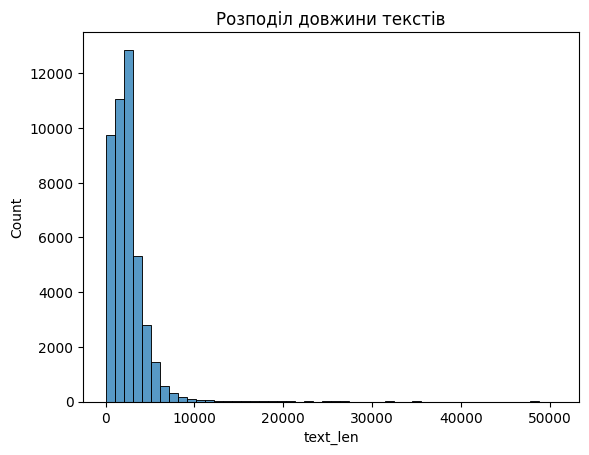

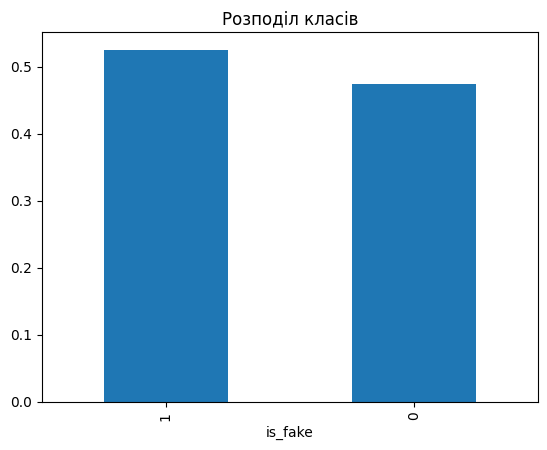

In [6]:
df["text_len"] = df["clean_text"].apply(len)
sns.histplot(df["text_len"], bins=50)
plt.title("Розподіл довжини текстів")
plt.show()

df["is_fake"].value_counts(normalize=True).plot(kind="bar", title="Розподіл класів")
plt.show()

## ✂️ 4. Поділ на train / test

In [7]:
X = df["clean_text"]
y = df["is_fake"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## ⚙️ 5. Baseline-модель (найчастіший клас)

In [8]:
most_common = y_train.mode()[0]
y_pred_baseline = [most_common] * len(y_test)
f1_baseline = f1_score(y_test, y_pred_baseline)
print("Baseline F1-score:", f1_baseline)

Baseline F1-score: 0.6887747615553925


## 📊 6. TF-IDF + XGBoost

In [9]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb.predict(X_test_tfidf)
f1_xgb = f1_score(y_test, y_pred_xgb)
print("XGBoost F1-score:", f1_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost F1-score: 0.9976555839727195


## 🌲 7. TF-IDF + Random Forest + важливі слова

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
f1_rf = f1_score(y_test, y_pred_rf)
print("Random Forest F1-score:", f1_rf)

Random Forest F1-score: 0.9970161977834612


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128288 (\N{INPUT SYMBOL FOR LATIN CAPITAL LETTERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


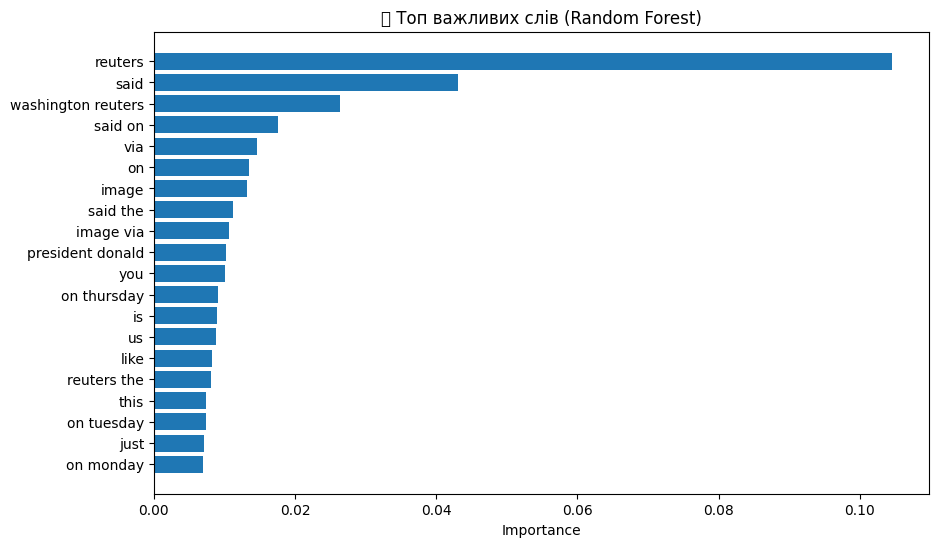

In [11]:
importances = rf.feature_importances_
feature_names = tfidf.get_feature_names_out()
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 6))
plt.barh(range(20), importances[indices])
plt.yticks(range(20), [feature_names[i] for i in indices])
plt.xlabel("Importance")
plt.title("🔠 Топ важливих слів (Random Forest)")
plt.show()

## 🤖 8. BERT — трансформер для класифікації

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len)
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(X_train, y_train, tokenizer, 512)
test_dataset = NewsDataset(X_test, y_test, tokenizer, 512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-14-1269933248.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.001200,0.041231
2,0.000100,0.005847


TrainOutput(global_step=8936, training_loss=0.038234965621760486, metrics={'train_runtime': 7433.1833, 'train_samples_per_second': 9.617, 'train_steps_per_second': 1.202, 'total_flos': 1.880928312557568e+16, 'train_loss': 0.038234965621760486, 'epoch': 2.0})

## 📈 9. BERT — оцінка

In [15]:
preds = trainer.predict(test_dataset)
y_pred_bert = np.argmax(preds.predictions, axis=1)
y_true_bert = preds.label_ids
f1_bert = f1_score(y_true_bert, y_pred_bert)
print("BERT F1-score:", f1_bert)

BERT F1-score: 0.9993606138107417


## 📊 10. Порівняльна таблиця результатів

In [17]:
results_df = pd.DataFrame({
    "Model": [
        "Baseline (Most Frequent Class)",
        "TF-IDF + XGBoost",
        "TF-IDF + Random Forest",
        "BERT (transformer fine-tuned)"
    ],
    "Precision": [
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_rf),
        precision_score(y_true_bert, y_pred_bert)
    ],
    "Recall": [
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_rf),
        recall_score(y_true_bert, y_pred_bert)
    ],
    "F1-score": [
        f1_baseline,
        f1_xgb,
        f1_rf,
        f1_bert
    ]
}).sort_values("F1-score", ascending=False).reset_index(drop=True)

results_df


,Model,Precision,Recall,F1-score
0,BERT (transformer fine-tuned),0.999787,0.998935,0.999361
1,TF-IDF + XGBoost,0.998081,0.997231,0.997656
2,TF-IDF + Random Forest,0.997441,0.996591,0.997016
3,Baseline (Most Frequent Class),0.525291,1.000000,0.688775
